In [ ]:
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
669394,0,2246246653,Fri Jun 19 17:18:36 PDT 2009,NO_QUERY,pico39,@elizabeth_ann all safe now. storm calm now. n...
133958,0,1836131994,Mon May 18 07:26:01 PDT 2009,NO_QUERY,stefanburt,my root canal anesthetic has now completely wo...
532589,0,2196817153,Tue Jun 16 12:58:19 PDT 2009,NO_QUERY,bkristin16,Guess i'm not going for a run stupid tornado...
419223,0,2061936664,Sat Jun 06 21:57:16 PDT 2009,NO_QUERY,bibliophile24_7,@mowglicorrea i forgot to post it.....geez. he...
854781,4,1573457406,Tue Apr 21 01:15:39 PDT 2009,NO_QUERY,melbm,@SonneEngel yes for 4 days with 2 friends *__*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


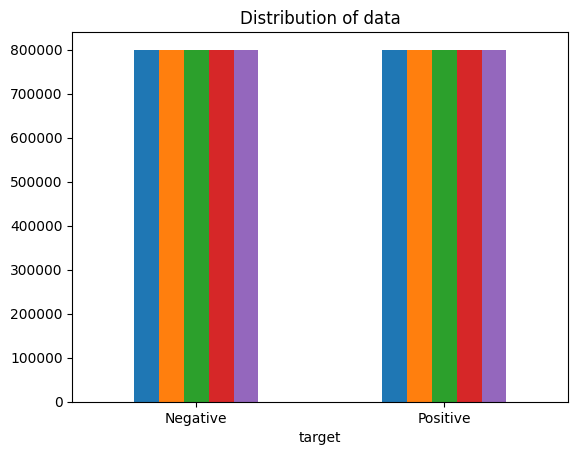

In [ ]:
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

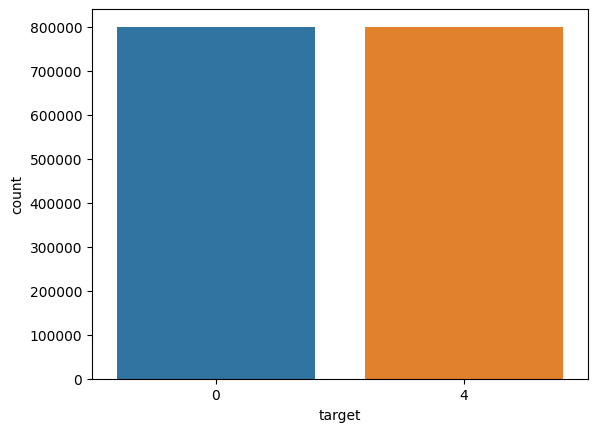

In [ ]:
import seaborn as sns
sns.countplot(x='target', data=df)

In [ ]:
data=df[['text','target']]

In [ ]:
data['target'] = data['target'].replace(4,1)

<ipython-input-10-54c9eb4fa536>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [ ]:
data['target'].unique()

array([0, 1])

In [ ]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [ ]:
data_pos = data_pos.iloc[:int(40000)]
data_neg = data_neg.iloc[:int(40000)]

In [ ]:
dataset = pd.concat([data_pos, data_neg])

In [ ]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

39995    have a quiz in spanish class tonday ..  but i ...
39996    @mittec no problems with it as such but i had ...
39997                                          ow my head 
39998    anyway... not particularly looking foreward to...
39999    allergies or insomnia? doesn't matter the reason 
Name: text, dtype: object

In [ ]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [ ]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

39995            quiz spanish class tonday  but think pass
39996    mittec no problems but literally spent 2 hours...
39997                                              ow head
39998    anyway not particularly looking foreward labs ...
39999              allergies insomnia doesnt matter reason
Name: text, dtype: object

In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

39995            quiz spanish class tonday  but think pass
39996    mittec no problems but literally spent 2 hours...
39997                                              ow head
39998    anyway not particularly looking foreward labs ...
39999              allergies insomnia doesnt matter reason
Name: text, dtype: object

In [ ]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

39995            quiz spanish class tonday  but think pass
39996    mittec no problems but literally spent 2 hours...
39997                                              ow head
39998    anyway not particularly looking foreward labs ...
39999              allergies insomnia doesnt matter reason
Name: text, dtype: object

In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

39995            quiz spanish class tonday  but think pass
39996    mittec no problems but literally spent  hours ...
39997                                              ow head
39998    anyway not particularly looking foreward labs ...
39999              allergies insomnia doesnt matter reason
Name: text, dtype: object

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [ ]:
import nltk
nltk.download('wordnet')
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [ ]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

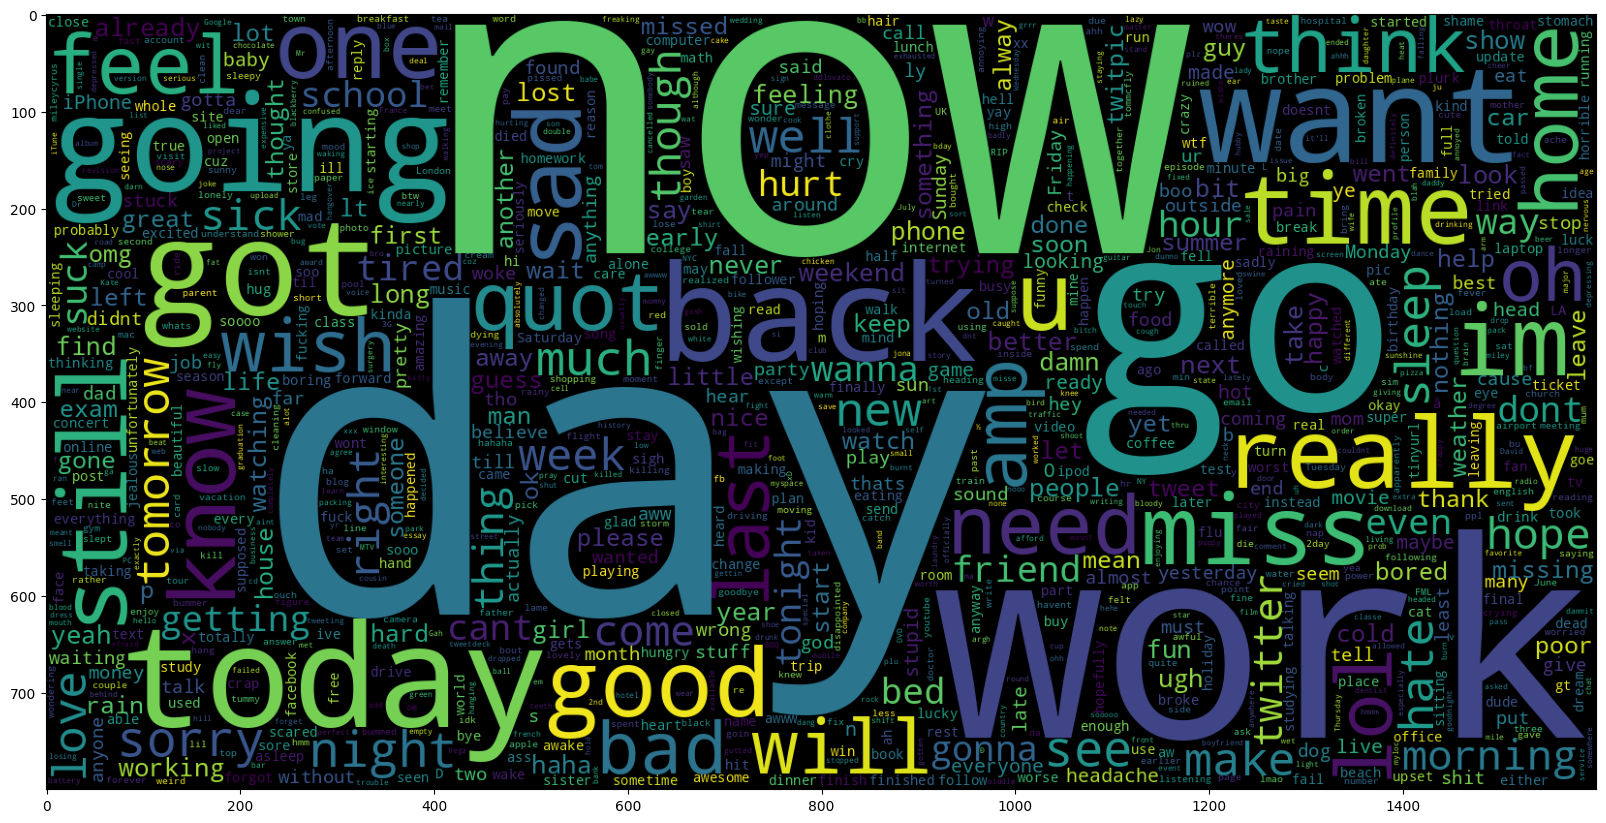

In [ ]:
X=data.text
y=data.target
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

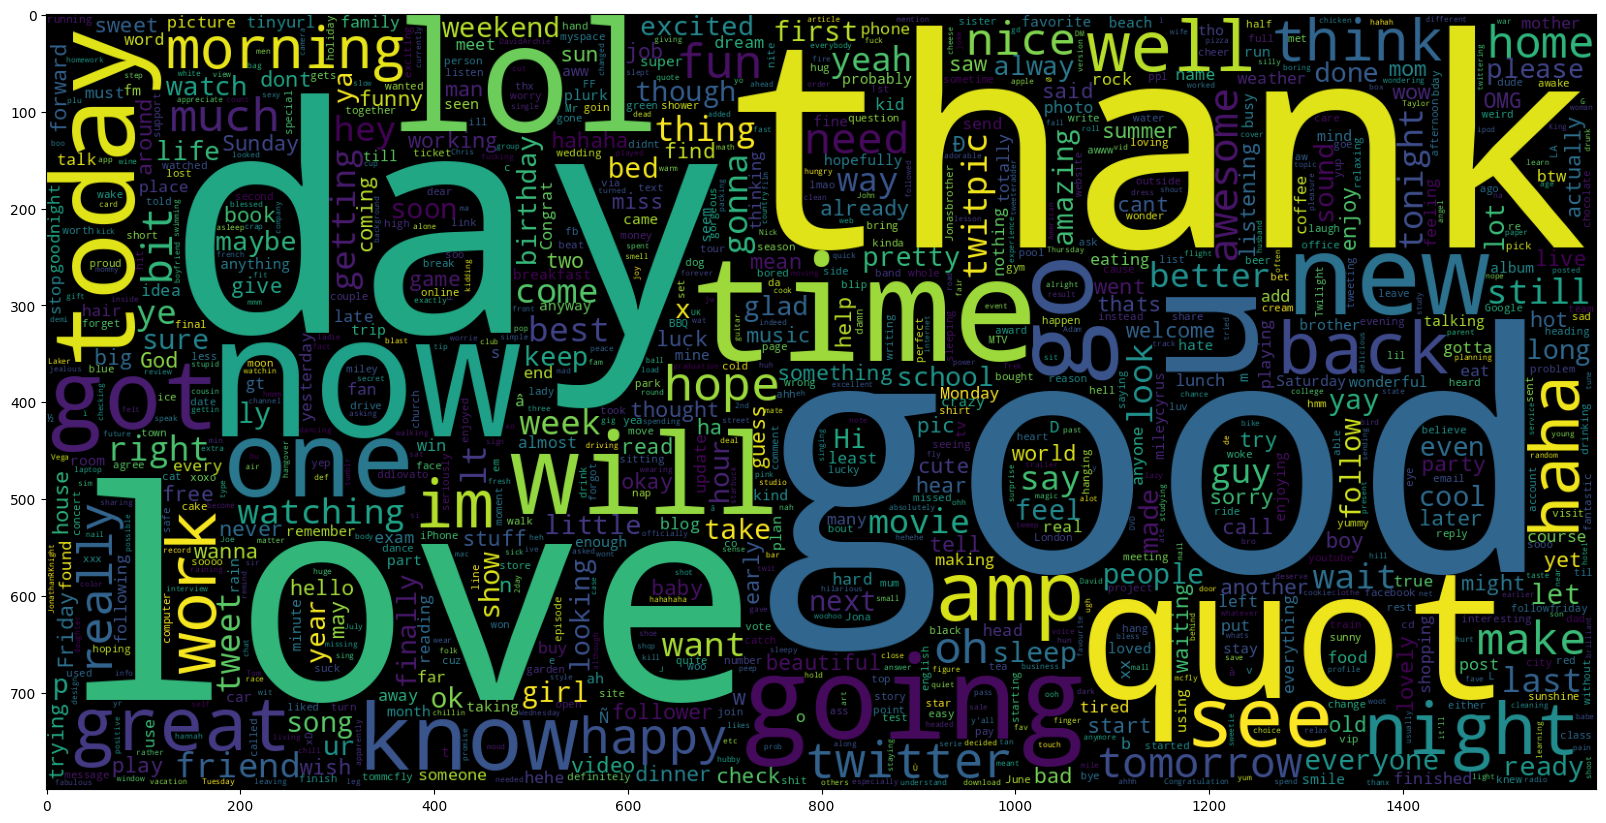

In [ ]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [ ]:
X=data.text
y=data.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


*   Bernoulli Naive Bayes Classifier
*   SVM (Support Vector Machine)
*   Logistic Regression

# Logistic Regression

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



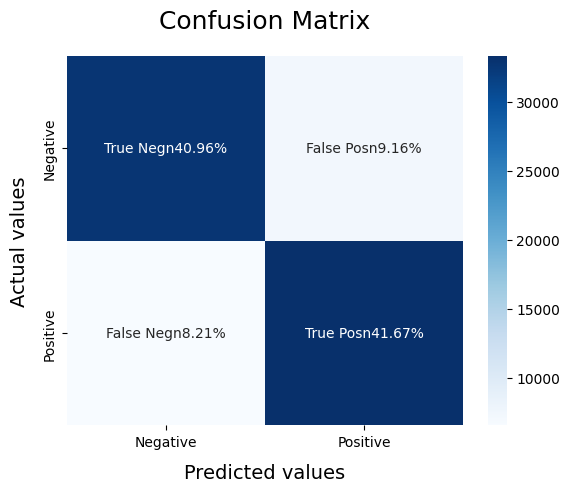

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

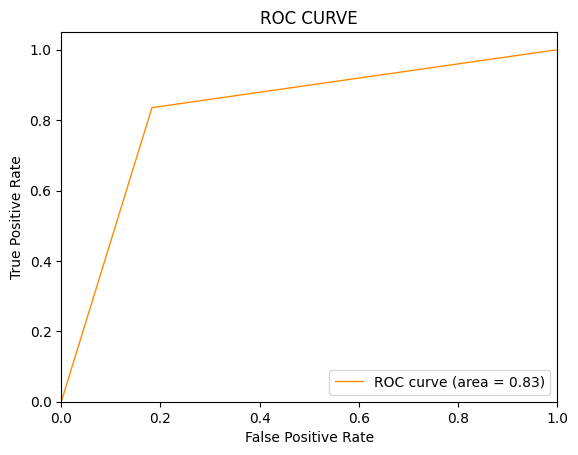

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC
SVM = SVC(C=1.0, kernel='linear', degree=1)

SVM.fit(X_train[:500000], y_train[:500000])
model_Evaluate(SVM)
y_pred4 = SVM.predict(X_test)

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred4)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     40100
           1       0.81      0.79      0.80     39900

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



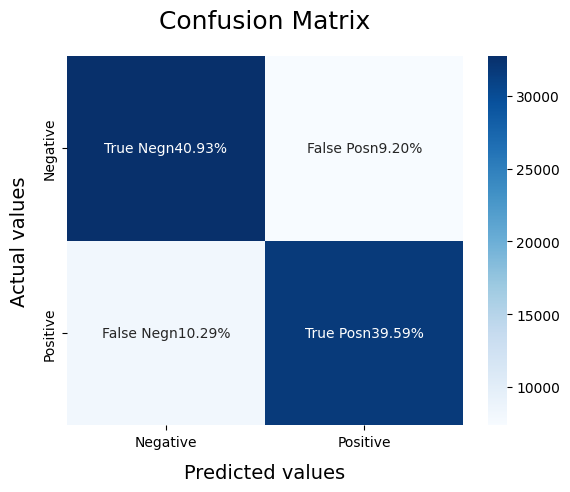

In [ ]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()

NB.fit(X_train, y_train)
model_Evaluate(NB)
y_pred5 = NB.predict(X_test)

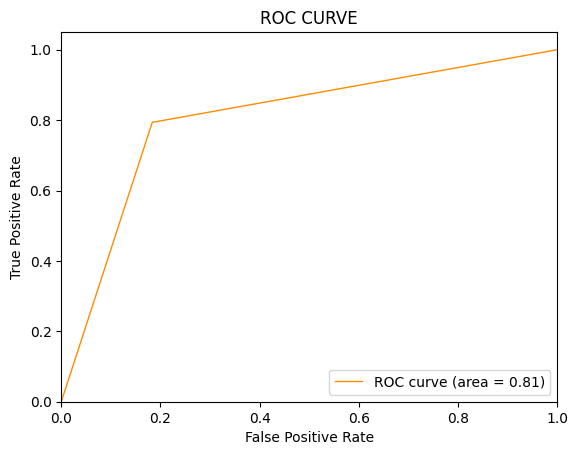

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred5)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# Random Forest Classifier

              precision    recall  f1-score   support

           0       0.74      0.74      0.74     40100
           1       0.74      0.73      0.74     39900

    accuracy                           0.74     80000
   macro avg       0.74      0.74      0.74     80000
weighted avg       0.74      0.74      0.74     80000



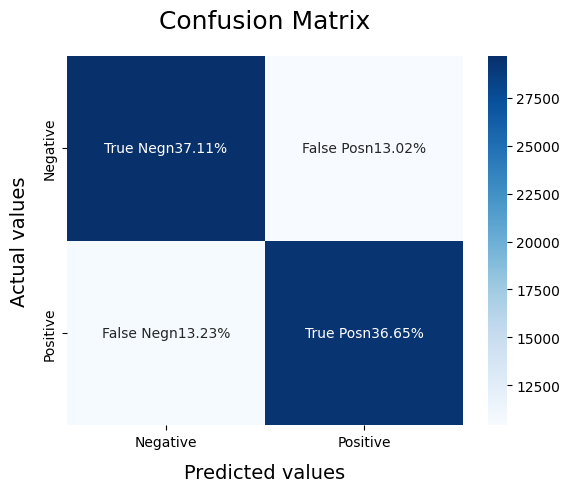

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators = 5)
RF.fit(X_train[:600000], y_train[:600000])
model_Evaluate(RF)
y_pred6 = RF.predict(X_test)

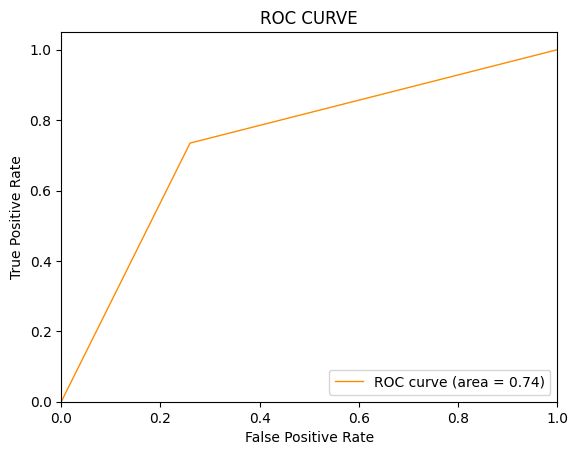

In [ ]:

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred6)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# Predictions

In [ ]:
def predict_sentiment(text, model, vectoriser):
  list_test = [text]
  X_test  = vectoriser.transform(list_test)
  # prediction
  Y_pred = model.predict(X_test)

  if (Y_pred[0]):
    print("positive")
  else:
    print("negative")


In [ ]:
import pickle

In [ ]:
# Save the model
with open('sentiment_analysis_model.pkl', 'wb') as file:
    pickle.dump(LRmodel, file)

In [ ]:
# Load the model
with open('sentiment_analysis_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
predict_sentiment("something went wrong", loaded_model)

negative


In [ ]:
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectoriser, file)
with open('vectorizer.pkl', 'rb') as file:
    loaded_vectorizer = pickle.load(file)